<a href="https://colab.research.google.com/github/machlovi/Spock-paper/blob/main/X_hate_and_offensive_data_combine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Implementation

## This file uses HateXplain data
We are initailizing 2 vector space for 3(after converting them into 2 class) classes in this code. Main idea is to visualize how we can separate words related to each classes in the given space


In [1]:
# ! apt-get install git
# !pip install --upgrade protobuf
# !pip install --upgrade jupyterlab-server google-api-core cached-path alchemy



# Import Libraries

In [2]:
# !pip install transformers --quiet

In [3]:
import os
import random
import pickle
from timeit import default_timer as timer
from tqdm import tqdm, trange


import re
import nltk
nltk.download("punkt")
from nltk.corpus import stopwords
nltk.download("stopwords")
from string import punctuation

import pandas as pd
import numpy as np
pd.set_option("display.max_rows",20)
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.utils import class_weight
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# from datasets import load_dataset,Dataset
from transformers import AutoModel, BertTokenizerFast, BertModel

from torch.utils.data import DataLoader

# Importing loss file
from custom_loss import CustomLoss, CosineSimilarityLoss, IntraClassLoss, BinaryCrossEntropyLoss, LossValues
from BERTdata_loader import BERTDataset



[nltk_data] Downloading package punkt to
[nltk_data]     /home/naseem_fordham/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/naseem_fordham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/naseem_fordham/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
# To display full column and rows values
# pd.set_option('display.max_column', None)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_seq_items', None)
# pd.set_option('display.max_colwidth', 500)
# pd.set_option('expand_frame_repr', True)

In [5]:
# !pip install numba

def on_gpu(f):
    def wrapper(*args):
        if torch.cuda.is_available():
            return f(*args)
        else:
            print('cuda unavailable')
    return wrapper


In [6]:
# This part of the code uses cuda for GPU utilization

In [7]:
if torch.cuda.is_available():
    # ! pip install pynvml
    from pynvml import *
    from numba import cuda

@on_gpu
def print_gpu_utilization(dev_id):
    try:
        nvmlInit()
        handle = nvmlDeviceGetHandleByIndex(dev_id)
        info = nvmlDeviceGetMemoryInfo(handle)
        print(f"GPU memory occupied: {info.used//1024**2} MB.")
    except Exception as e:
        print(e)

@on_gpu
def free_gpu_cache(dev_id=0):
    print("Initial GPU Usage")
    print_gpu_utilization(dev_id)

    torch.cuda.empty_cache()

    print("GPU Usage after emptying the cache")
    print_gpu_utilization(dev_id)

def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [8]:
device_id = 0
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
print(device)

print_gpu_utilization(device_id)


cuda:0
GPU memory occupied: 13780 MB.


In [9]:
# MODEL_NAME = 'distilbert-base-cased'
# MODELS_PATH = 'models'
# DATASET_NAME = 'imdb'


### Hate and offesive data

In [10]:
# def text_preprocessing(text,                                                               # text is a word string ex. 'rahul in ny'
#                       punctuations = r'''!()-[]{};:'"\,<>./?@#$%^&*_“~='ã¶``''',
#                       stop_words = set(stopwords.words("english"))) -> list:

#         '''
#         A method to preprocess text

#         '''

#         for x in text.lower():
#             if x in punctuations:
#                 text = text.replace(x,"")

#         # removing words that have numbers in them
#         text = re.sub(r'\w*\d\w*', '', text)
#         # remove digits
#         text = re.sub(r'[0-9]+', ' ', text)

#         # clean the whitespaces

#         text = re.sub(r'\s+', ' ', text).strip()



#         # convert all text to a list

#         # text = text.split(' ').  # uncomment if list required
#         emoji_pattern = re.compile("["
#                                    u"\U0001F600-\U0001F64F"  # emoticons
#                                    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                                    u"\U0001F680-\U0001F6FF"  # transport & map symbols
#                                    u"\U0001F700-\U0001F77F"  # alchemical symbols
#                                    u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
#                                    u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
#                                    u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
#                                    u"\U0001FA00-\U0001FA6F"  # Chess Symbols
#                                    u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
#                                    u"\U00002702-\U000027B0"  # Dingbat symbols
#                                    u"\U000024C2-\U0001F251" 
#                                    "]+", flags=re.UNICODE)
#         text = emoji_pattern.sub(r'', text)

#         # lowercase eth

#         text = text.lower()


#         # drop the stop words



#         # add the tags

#         return text

# HateOffensive data

https://github.com/t-davidson/hate-speech-and-offensive-language/tree/master/data#Data import

Data Source "https://github.com/t-davidson/33 ##
hate-speech-and-offensive-language/blob/master/data/readme.md"
'''hate_speech = number of CF users who judged the tweet to be hate speech.
offensive_language = number of CF users who judged the tweet to be offensive.
neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.
class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither'''
In this case 0 non-toxic and 1 -toxic



In [11]:
# #loading hate ofefsive data and converting it into 2 class data as toxic and non-toxic
# df_data1=pd.read_csv("/home/naseem_fordham/Spock-paper/data/labeled_data.csv")
# dataframe=df_data1[['class','tweet']]
# dataframe=dataframe.dropna()
# dataframe.reset_index(drop=True)
# dataframe['class'].unique()

# # #initially we have 3 classes and now we are converting them into binary class

# dataframe["class"] = dataframe["class"].apply(lambda x: 1.0 if x in [0., 1.] else 0.0)
# # HateXplain["label"] = HateXplain["label"].apply(lambda x: 1.0 if x in ["hatespeech", "offensive"] else 0.0)

# dataframe["tweet"] = dataframe["tweet"].apply(lambda x : text_preprocessing(x))
# dataframe = dataframe.sample(frac = 1).reset_index(drop = True)

# # dataframe=HateXplain
# dataframe['class'].unique()
# # dataframe.tail(4)

In [12]:
# dataframe['class'].value_counts()

### Xhate-999 data set
Class 1 hate, Class 0 non-hate speech

In [13]:
# @title
# # Use this part for single file
# # Define the path to your text file
# file_path = "/gdrive/MyDrive/SPOCK/Dataset/xhate-main/train/XHate999-EN-Gao-train.txt"

# # Initialize empty lists to store data
# tweets = []
# labels = []

# # Read the file line by line
# with open(file_path, 'r') as file:
#     for line in file:
#         # Split the line into text and label using the last character
#         line = line.strip()  # Remove leading/trailing whitespace
#         text = line[:-2].strip()  # Extract text (excluding the last character)
#         label = line[-1]  # Extract the label (as an integer)

#         # Append data to lists
#         tweets.append(text)
#         labels.append(label)

# # Create a DataFrame from the lists
# df = pd.DataFrame({'Text': tweets, 'Label': labels})
# df.drop(0,inplace=True)

# # Display the DataFrame
# print(df)


In [14]:
# import os
# import glob

# # Define the directory path where your text files are located
# directory_path = "/gdrive/MyDrive/SPOCK/Dataset/xhate-main/train"

# # Initialize empty lists to store data
# tweets = []
# labels = []

# # Loop through all text files in the specified directory
# for filename in glob.glob(os.path.join(directory_path, '*.txt')):
#     with open(filename, 'r') as file:

#       for line in file:
#           # Split the line into text and label using the last character
#           line = line.strip()  # Remove leading/trailing whitespace
#           text = line[:-2].strip()  # Extract text (excluding the last character)
#           label = line[-1]  # Extract the label (as an integer)

#           # Append data to lists
#           tweets.append(text)
#           labels.append(label)

# # Create a DataFrame from the lists
# df = pd.DataFrame({'tweet': tweets, 'class': labels})
# df.drop(0,inplace=True)


# df['class']=pd.to_numeric(df['class'], errors='coerce')
# df['class'].fillna(0, inplace=True)
# df['class']=df['class'].astype(int)
# df_hate2=df[df['class']==1]
# df_nonhate2=df[df['class']==0]

##Combing hatespeech and xhate data for hate/offensive class

# HateXplain Dataset
Hate speech is a challenging issue plaguing the online social media. While better models for hate speech detection are continuously being developed, there is little research on the bias and interpretability aspects of hate speech. In this work, we introduce HateXplain, the first benchmark hate speech dataset covering multiple aspects of the issue. Each post in our dataset is annotated from three different perspectives: the basic, commonly used 3-class classification (i.e., hate, offensive or normal), the target community (i.e., the community that has been the victim of hate speech/offensive speech in the post), and the rationales

In this case we are using Toxic and Non-toxic

### Here we have implenting attenstion score for HateXplain

In [15]:
# data_path =  "/home/naseem_fordham/Spock-paper/data/Hate_Xplain.json"  # Replace this with the actual path to your data file
# processor = HateXplain(data_path)

# # Call the preprocess_data method to preprocess the data
# processed_data = processor.preprocess_data()

# # Now you can work with the processed data as needed
# print(processed_data.head()) 

In [16]:
import pandas as pd
from preprocess import TextPreprocessor  # Import your TextPreprocessor class


text_processor = TextPreprocessor()

# Continue with the rest of your code...

df = pd.read_json("/home/naseem_fordham/Spock-paper/data/Hate_Xplain.json")
df_t=df.T
df = pd.read_json("/home/naseem_fordham/Spock-paper/data/Hate_Xplain.json")
df_t=df.T
#  extracting each label from nester list
df_t['annotators0']=df_t['annotators'].apply(lambda x: x[0]['label'])
df_t['annotators1']=df_t['annotators'].apply(lambda x: x[1]['label'])
df_t['annotators2']=df_t['annotators'].apply(lambda x: x[2]['label'])

# laeblling

df_t['annotators0']=df_t['annotators0'].apply(lambda x: 0.0 if x == "hatespeech" else (1.0 if x == "offensive" else 2.0))
df_t['annotators1']=df_t['annotators1'].apply(lambda x: 0.0 if x == "hatespeech" else (1.0 if x == "offensive" else 2.0))
df_t['annotators2']=df_t['annotators2'].apply(lambda x: 0.0 if x == "hatespeech" else (1.0 if x == "offensive" else 2.0))

# dropping some unnecessary columns
df_t.drop(['post_id','annotators'],axis=1,inplace=True)

# sperating non_toxic
df_n = df_t[((df_t['annotators0'] == 2.0) & (df_t['annotators1'] == 2.0) & (df_t['annotators2'] == 2.0)) | (df_t['rationales'].apply(lambda x: len(x) == 0))]
df_n['label']='non_toxic'

#Generating rationles values for non-rationles by deving the 1 by the total length
df_n['leng']=df_n['post_tokens'].apply(lambda x: len(x))
df_n['rationales'] = df_n['leng'].apply(lambda length: [1/length] *length )


#separating toxic
df_ho = df_t[~df_t.index.isin(df_n.index)]


# taking mean of rationales
df_ho['rationales1']=df_ho['rationales'].apply(lambda x: x[0])
df_ho['rationales2']=df_ho['rationales'].apply(lambda x: x[1])
df_ho['rationales3']=df_ho['rationales'].apply(lambda x: x[2:3])

df_ho['sum_result'] = df_ho.apply(lambda row: [a + b + c for a, b, c in zip(row['rationales1'], row['rationales2'],row['rationales1'])], axis=1)
df_ho['mean']=df_ho['sum_result'].apply(lambda x: [val /3 for val in x])

df_toxic=df_ho[['post_tokens','mean']].rename(columns={'mean':'rationales'})
df_toxic['label']='toxic'

df_combine = pd.concat([df_toxic,df_n[['post_tokens','label','rationales']]]).reset_index(drop=True)


df_combine["post_tokens"].values
for i in range(len(df_combine["post_tokens"])):
    df_combine["post_tokens"][i] = " ".join(df_combine["post_tokens"][i])

# df_combine["post_tokens"] = df_combine["post_tokens"].apply(lambda x : text_preprocessing(x))
df_combine["post_tokens"] = df_combine["post_tokens"].apply(lambda x : text_processor.text_preprocessing(x))

df_combine.rename(columns={"post_tokens":"tweet","label":"class"},inplace=True)
# dataframe=df_combine.sample(frac = 1).reset_index(drop = True)
df_combine.head(10)


/tmp/ipykernel_1639900/4192771600.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n['label']='non_toxic'
/tmp/ipykernel_1639900/4192771600.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n['leng']=df_n['post_tokens'].apply(lambda x: len(x))
/tmp/ipykernel_1639900/4192771600.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

,tweet,rationales,class
0,user i am bit confused coz chinese ppl can not...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",toxic
1,this bitch in whataburger eating a burger with...,"[0.0, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0, ...",toxic
2,laura loomer raped me while screaming at me in...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",toxic
3,and this is why i end up with nigger trainee d...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",toxic
4,nogs jews and dykes how enriching,"[1.0, 1.0, 0.6666666666666666, 1.0, 0.0, 0.0]",toxic
5,guilty until proven innocent unless you are a ...,"[0.0, 0.0, 0.0, 0.0, 0.6666666666666666, 0.666...",toxic
6,tired i can not support abortion from a moral ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",toxic
7,number number percent of brits think multicult...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",toxic
8,all of my exes were cute but they were hoes i ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",toxic
9,user condoning drug use not kike at all thanks...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",toxic


In [17]:
''' We have implemented temperature function to change the rationale for sensible. 
low temperature softmax probs : [0.01,0.01,0.98]
high temperature softmax probs : [0.2,0.2,0.6]
since we want to differentiate using ket waord we need to use low value'''


dataframe=df_combine.copy()

dataframe["tweet"] = dataframe["tweet"].apply(lambda x : text_processor.text_preprocessing(x))
dataframe["class"] = dataframe["class"].apply(lambda x: 1.0 if x =="non_toxic" else 0.0)


Temprature=0.25
dataframe['rationales_T']= dataframe['rationales'].apply(lambda x: [val /Temprature for val in x])
def softmax(x):
    e_x = np.exp(x - np.max(x))
    softmax_values= e_x / e_x.sum(axis=0)
    return np.round(softmax_values, 3)

# Apply softmax to the 'numbers' column
dataframe['softmax_numbers'] = dataframe['rationales_T'].apply(softmax)

In [18]:
dataframe=dataframe[['tweet','class','softmax_numbers']]
dataframe

,tweet,class,softmax_numbers
0,user i am bit confused coz chinese ppl can not...,0.0,"[0.008, 0.008, 0.008, 0.008, 0.008, 0.008, 0.0..."
1,this bitch in whataburger eating a burger with...,0.0,"[0.005, 0.073, 0.005, 0.005, 0.005, 0.005, 0.0..."
2,laura loomer raped me while screaming at me in...,0.0,"[0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.0..."
3,and this is why i end up with nigger trainee d...,0.0,"[0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.0..."
4,nogs jews and dykes how enriching,0.0,"[0.303, 0.303, 0.08, 0.303, 0.006, 0.006]"
...,...,...,...
20143,it a bitch to find i accidently opened it how ...,1.0,"[0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.0..."
20144,anybody notice anything strange on gab like so...,1.0,"[0.026, 0.026, 0.026, 0.026, 0.026, 0.026, 0.0..."
20145,graph straftaten gegen die sexuelle selbstbest...,1.0,"[0.037, 0.037, 0.037, 0.037, 0.037, 0.037, 0.0..."
20146,an afghani immigrant once told me that in afgh...,1.0,"[0.023, 0.023, 0.023, 0.023, 0.023, 0.023, 0.0..."


In [19]:
# # HateXplain Dataset converting into binary class
# HateXplain = pd.read_csv('/home/naseem_fordham/Spock-paper/data/Hate_Xplain.csv')
# HateXplain["label"] = HateXplain["label"].apply(lambda x: 1.0 if x in ["hatespeech", "offensive"] else 0.0)
# # HateXplain["label"] = HateXplain["label"].apply(lambda x: 1.0 if x in ["hatespeech", "offensive"] else 0.0)

# HateXplain["text"] = HateXplain["text"].apply(lambda x : text_preprocessing(x))
# HateXplain = HateXplain.sample(frac = 1).reset_index(drop = True)
# HateXplain.rename(columns={"text":"tweet","label":"class"},inplace=True)
# dataframe=HateXplain
# dataframe['class'].unique()
# dataframe.head(4)

In [20]:
# df_hate_combine=pd.concat([df_hate,df_hate2]).reset_index(drop=True)
# df_nonhat_combine=pd.concat([df_peace,df_nonhate2]).reset_index(drop=True)

In [21]:
# df_hate_combine["tweet"] = df_hate_combine["tweet"].apply(lambda x : text_preprocessing(x))
# df_nonhat_combine["tweet"] = df_nonhat_combine["tweet"].apply(lambda x : text_preprocessing(x))

In [22]:
# dataframe=pd.concat([df_hate_combine ,df_nonhat_combine]).reset_index(drop=True)
# dataframe.dropna(inplace=True)


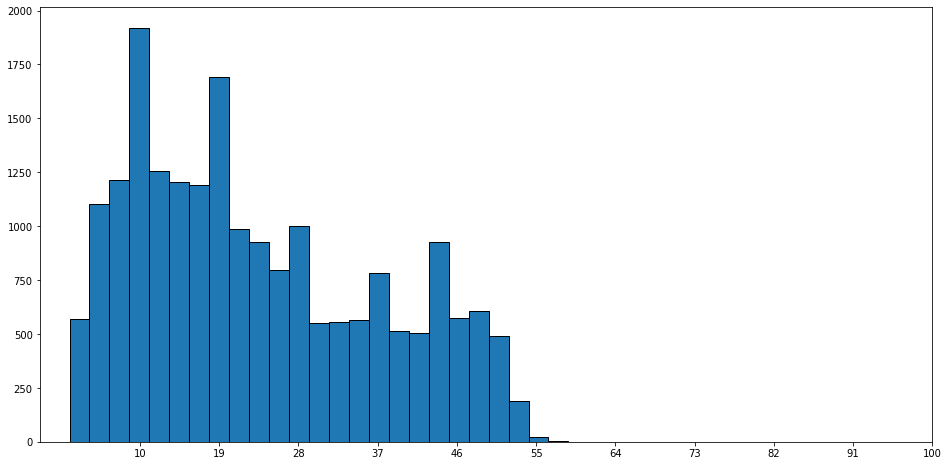

In [23]:
# token lengths distribution in the dataset
token_lengths = [len(i.split()) for i in dataframe["tweet"]]
plt.figure(figsize=(16,8))
plt.hist(token_lengths,bins = 30,edgecolor="black")
plt.xticks(ticks = np.linspace(10,100,11))
plt.show()
dataframe["token_length"] = token_lengths

# Training and validation set
We can also consider token length

In [24]:
# token_length 128, seems a good fit for data

# split training and validation data
train_df, val_df = train_test_split(dataframe, test_size= 0.20, stratify= dataframe["class"], random_state = 40)

# val_df,   test_df   = train_test_split(temp_df, test_size= 0.80, stratify= temp_df["class"],random_state = 47)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop  = True)
# test_df  = test_df.reset_index(drop = True)

In [25]:
# load bertModel, bertTokenizer and freeze all layers
bertModel = AutoModel.from_pretrained("bert-base-uncased").to(device)
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
bertModel.trainable = False # freezing the weights

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
#getting model total number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(bertModel)


109482240

# Dataset creation for BERT Model

In [27]:
from BERTdata_loader import BERTDataset
bert_dataset = BERTDataset(text=None, labels=None, attention_scores=None, max_length=None, tokenizer=None, projection_dim=None)



# Paramters

In [30]:
class remove_pads(nn.Module):
    def __init__(self, vocab_size, embedding_dim, **kwargs):
        super(remove_pads, self).__init__(**kwargs)
        self.mask_generator = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

    def forward(self, inputs, input_ids):
        masks = self.mask_generator(input_ids)
        masks = masks.float().unsqueeze(-1)
        temp = masks.unbind(dim=1)
        del temp[0]
        temp.insert(0, torch.zeros_like(temp[0]))
        masks = torch.stack(temp, dim=1)
        length = masks.sum(dim=1, keepdim=True)
        masked_embeddings = inputs * masks
        masked_embeddings = masked_embeddings.sum(dim=1, keepdim=True)
        masked_embeddings /= length
        return masked_embeddings


class remove_padsV2(nn.Module):
    def __init__(self, vocab_size, embedding_dim, **kwargs):
        super(remove_padsV2, self).__init__(**kwargs)
        self.mask_generator = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

    def forward(self, inputs, input_ids):
        filtered_input_ids = torch.where((input_ids == 101) | (input_ids == 102), torch.tensor(0), input_ids)
        masks = self.mask_generator(filtered_input_ids)
        masks = masks.float().unsqueeze(-1)
        masked_embeddings = inputs * masks
        return masked_embeddings





 

Loading Weights

# Model Architecture

In [70]:

class SpockModel(nn.Module):
    def __init__(self, MAX_LENGTH, PROJECTION_DIM, lambda_value):
        super(SpockModel, self).__init__()
        self.MAX_LENGTH = MAX_LENGTH
        self.PROJECTION_DIM = PROJECTION_DIM
        self.lambda_value = lambda_value
        self.VECTOR_DIM = 768

        # Layers
        self.bert_model = bertModel  # Assuming you have defined bertModel elsewhere
        self.offensive_embedding_layer = nn.Embedding(PROJECTION_DIM, self.VECTOR_DIM)
        self.normal_embedding_layer = nn.Embedding(PROJECTION_DIM, self.VECTOR_DIM)

        self.hidden1 = nn.Linear(2 * self.PROJECTION_DIM, 256)
        # self.hidden2 = nn.Linear(612, 256)
        self.hidden3 = nn.Linear(256, 64)
        self.hidden4 = nn.Linear(64, 30)
        self.classification_layer = nn.Linear(30, 1)
        
        

        # Loss Functions
        self.cosine_loss = CosineSimilarityLoss(name='cosine_loss')
        self.intra_loss = IntraClassLoss(name='intra_loss')
        self.bce_loss = BinaryCrossEntropyLoss(name='attention_loss')
        # self.loss_values = LossValues()


    def forward(self, ids, mks, projection_space, attention_score):
        input_sentence = self.bert_model(ids, attention_mask=mks)[0].to(device)

        offensive_embedding_np = self.offensive_embedding_layer(projection_space)
        normal_embedding_np = self.normal_embedding_layer(projection_space)

        offensive_embedding = offensive_embedding_np.permute(0, 2, 1)
        normal_embedding = normal_embedding_np.permute(0, 2, 1)

        offensive_cosine = self.cosine_similarity_projected(input_sentence, offensive_embedding)
        normal_cosine = self.cosine_similarity_projected(input_sentence, normal_embedding)

        offensive_cosine_nopads = self.remove_padsV2(offensive_cosine, ids)
        normal_cosine_nopads = self.remove_padsV2(normal_cosine, ids)

        merged = self.merge_functionV2(offensive_cosine_nopads, normal_cosine_nopads)
        merged = merged.view(-1, 2 * self.PROJECTION_DIM)

        hidden1 = F.relu(self.hidden1(merged))
        # hidden2 = F.relu(self.hidden2(hidden1))
        hidden3 = F.relu(self.hidden3(hidden1))
        hidden4 = F.relu(self.hidden4(hidden3))

        predictions = torch.sigmoid(self.classification_layer(hidden4))
        # print(predictions)

        # # Losses
        offensive_normal_loss = self.cosine_loss(torch.mean(offensive_cosine, dim=1), torch.mean(normal_cosine, dim=1))
        toxic_intra_loss = self.intra_loss(offensive_cosine)
        non_toxic_intra_loss = self.intra_loss(normal_cosine)
        bce_loss1 = self.bce_loss(attention_score, hidden4)

        # Total Loss
        # + self.lambda_value * bce_loss1
        loss = offensive_normal_loss + toxic_intra_loss + non_toxic_intra_loss + self.lambda_value * bce_loss1
        
        # self.loss_values.update(offensive_normal_loss, toxic_intra_loss, non_toxic_intra_loss, bce_loss1)
        


        return predictions,loss,offensive_normal_loss, toxic_intra_loss, non_toxic_intra_loss, bce_loss1
    
    
    def cosine_similarity_projected(self, x, w):
        dp = torch.matmul(x, w)
        x_mag = torch.norm(x, dim=2, keepdim=True)
        w_mag = torch.norm(w, dim=1, keepdim=True)
        cosine = dp / (x_mag * w_mag)
        return cosine

    def remove_padsV2(self, vects, ids):
        masks = ids != 0
        masks = masks.unsqueeze(-1).float()
        masked_embeddings = vects * masks
        return masked_embeddings

    def merge_functionV2(self, negative, normal):
        negative_max = torch.max(negative, dim=1, keepdim=True)[0]
        normal_max = torch.max(normal, dim=1, keepdim=True)[0]
        return torch.cat([negative_max, normal_max], dim=-1)




# Model Training and Saving 

In [72]:
def eval(f):
    def wrapper(model, *args, **kwargs):
        model.eval()
        return f(model, *args, **kwargs)
    return wrapper

def train(f):
    def wrapper(model, *args, **kwargs):
        model.train()
        return f(model, *args, **kwargs)
    return wrapper

In [73]:
# train_dataloader,val_dataloader=dataprep(3)
s=1
@train
def train_epoch(model, train_dataloader, optimizer):
    train_loss = 0.0
    train_preds = []
    train_labels = []

    for step, batch in enumerate(train_dataloader):
        # print(step)
        # if step==1:
        
        
        input_ids = batch['input_ids'].to(device)
        attention_masks = batch['attention_masks'].to(device)
        space = batch['space'].to(device)
        attention_score = batch['attention_score'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_masks, space, attention_score) # (B, Seq_Len, 2)
        preds,loss,train_offensive_normal_loss,train_toxic_intra_loss, train_non_toxic_intra_loss, train_bce_loss1= outputs
        loss = torch.mean(loss)  # Compute the mean loss across the batch    
        
        labels = labels.view(-1, 1).float()
        
        bce_loss = nn.BCEWithLogitsLoss()(preds.view(-1,1), labels.float())
        loss += bce_loss
        
        train_preds += preds.detach().tolist()
        train_labels += [l.item() for l in labels]

        optimizer.zero_grad()

        loss.backward()
                        
        optimizer.step()

        train_loss += loss.item()
        # else:
        #     break
    return train_loss, train_preds, train_labels,train_offensive_normal_loss,train_toxic_intra_loss, train_non_toxic_intra_loss, train_bce_loss1

@eval
def eval_epoch(model, val_dataloader):
    val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():

        for step, batch in enumerate(val_dataloader):
            # if step==1:
            input_ids = batch['input_ids'].to(device)
            attention_masks = batch['attention_masks'].to(device)
            space = batch['space'].to(device)
            attention_score = batch['attention_score'].to(device)
            labels = batch['label']

            outputs = model(input_ids, attention_masks, space, attention_score) # (B, Seq_Len, 2)

            # loss, logits = outputs.loss, outputs.logits
            preds,loss,val_offensive_normal_loss, val_toxic_intra_loss, val_non_toxic_intra_loss, val_bce_loss1 = outputs
            loss=torch.mean(loss)
            # print(preds.dtype)


            # probs = F.softmax(logits, dim=-1)

            # pred = torch.argmax(probs, dim=-1) # (B)
            val_preds += preds.detach().tolist()
            val_labels += [l.item() for l in labels]
            # print(val_labels,val_preds)
            val_loss += loss.item()
        # else:
        #     continue

               
    return val_loss, val_preds, val_labels,val_offensive_normal_loss, val_toxic_intra_loss, val_non_toxic_intra_loss, val_bce_loss1

In [74]:
#Metrices
def training(model, train_data, val_data, config):
    model = model

    optimizer = torch.optim.Adam(
        params=model.parameters(),
        lr=config['lr'],
        weight_decay=config['weight_decay']
    )

    num_train_steps = int(len(train_data) / config['batch_size'] * config['epochs'])
    num_train_steps=2

    print(f'Train steps: {num_train_steps}')

    # train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=config['batch_size'], shuffle=True)
    # val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=config['val_batch_size'])

    history = {
        'train_losses': [],
        'val_losses': [],
        'train_acc': [],
        'val_acc': [],
        'train_f1': [],
        'val_f1': [],
        'train_precision': [],
        'val_precision': [],
        'train_recall': [],
        'val_recall': [],
        'train_offensive_normal_loss': [],
        'train_toxic_intra_loss': [],
        'train_non_toxic_intra_loss': [],
        'train_bce_loss1': [],
        'val_offensive_normal_loss': [],
        'val_toxic_intra_loss': [],
        'val_non_toxic_intra_loss': [],
        'val_bce_loss1': []
    }
    # Inside the training loop
    for epoch_num in range(config['epochs']):
        print(f'Epoch: {epoch_num + 1}')

        # Train stage
        train_loss, train_preds, train_labels,train_offensive_normal_loss,train_toxic_intra_loss, train_non_toxic_intra_loss, train_bce_loss1 = train_epoch(model, train_dataloader, optimizer)

        # Eval stage
        val_loss, val_preds, val_labels,val_offensive_normal_loss, val_toxic_intra_loss, val_non_toxic_intra_loss, val_bce_loss1 = eval_epoch(model, val_dataloader)


        train_preds_tensor = torch.tensor(train_preds)
        val_preds_tensor = torch.tensor(val_preds)

        # Get class labels using argmax
        train_preds_labels = torch.argmax(train_preds_tensor, dim=1).cpu().numpy()
        val_preds_labels = torch.argmax(val_preds_tensor, dim=1).cpu().numpy()
        
        
                

        # Metrics calculation
        train_acc = accuracy_score(train_labels, train_preds_labels)
        val_acc = accuracy_score(val_labels, val_preds_labels)
        train_f1 = f1_score(train_labels, train_preds_labels, average='macro')
        val_f1 = f1_score(val_labels, val_preds_labels, average='macro')
        train_precision = precision_score(train_labels, train_preds_labels, average='weighted')
        val_precision = precision_score(val_labels, val_preds_labels, average='weighted')
        train_recall = recall_score(train_labels, train_preds_labels, average='weighted')
        val_recall = recall_score(val_labels, val_preds_labels, average='weighted')

        # Update history dictionary
        history['train_losses'].append(train_loss / len(train_dataloader))
        history['val_losses'].append(val_loss / len(val_dataloader))
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        history['train_precision'].append(train_precision)
        history['val_precision'].append(val_precision)
        history['train_recall'].append(train_recall)
        history['val_recall'].append(val_recall)


        
        history['train_offensive_normal_loss'].append(train_offensive_normal_loss.detach().cpu().numpy())
        history['train_toxic_intra_loss'].append(train_toxic_intra_loss.detach().cpu().numpy())
        history['train_non_toxic_intra_loss'].append(train_non_toxic_intra_loss.detach().cpu().numpy())
        history['train_bce_loss1'].append(train_bce_loss1.detach().cpu().numpy())

        # Append validation loss values
        history['val_offensive_normal_loss'].append(val_offensive_normal_loss.detach().cpu().numpy())
        history['val_toxic_intra_loss'].append(val_toxic_intra_loss.detach().cpu().numpy())
        history['val_non_toxic_intra_loss'].append(val_non_toxic_intra_loss.detach().cpu().numpy())
        history['val_bce_loss1'].append(val_bce_loss1.detach().cpu().numpy())

        print()
        print(f'Train loss: {train_loss / len(train_dataloader)} | Val loss: {val_loss / len(val_dataloader)}')
        print(f'Train acc: {train_acc} | Val acc: {val_acc}')
        print(f'Train f1: {train_f1} | Val f1: {val_f1}')
        print(f'Train precision: {train_precision} | Val precision: {val_precision}')
        print(f'Train recall: {train_recall} | Val recall: {val_recall}')
        
        

    # Free GPU cache if necessary
    free_gpu_cache(device_id)

    return history


In [75]:
print_gpu_utilization(device_id)
torch.cuda.empty_cache()
free_gpu_cache(device_id)

GPU memory occupied: 19739 MB.
Initial GPU Usage
GPU memory occupied: 18573 MB.
GPU Usage after emptying the cache
GPU memory occupied: 18573 MB.


In [76]:

MAX_LEN = 30
PROJECTION_DIM = 2
NUM_EPOCHS=10
BATCH_SIZE=32
LEARNING_RATE=0.001
w1=0.5
w2=0.5

# VECTOR_DIM = 768
lambda_value = 0.2
EPOCHS = 3

# Initialize model
spock_model = SpockModel(MAX_LEN, PROJECTION_DIM, lambda_value)
# spock_model.to(device)


# train_dataloader,val_dataloader=dataprep(PROJECTION_DIM)
# Call the dataprep method on the object
train_dataloader,val_dataloader = bert_dataset.dataprep(train_df, val_df, tokenizer, MAX_LEN, BATCH_SIZE, PROJECTION_DIM)

config = {
    'epochs': NUM_EPOCHS,
    'batch_size': BATCH_SIZE,
    'val_batch_size': BATCH_SIZE,
    
    'gradient_accumulation_steps': 1,
    'fp16': False,
    'lr': LEARNING_RATE,
    # 'max_grad_norm': MAX_GRAD_NORM,
    'weight_decay': 0.01,
}
history = training(spock_model.to(device), train_dataloader, val_dataloader, config)
# torch.cuda.empty_cache()

Train steps: 2
Epoch: 1


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Train loss: 5.5883534238452 | Val loss: 4.357758752883426
Train acc: 0.5665715349298921 | Val acc: 0.5665012406947891
Train f1: 0.3616633663366337 | Val f1: 0.3616347220022177
Train precision: 0.3210033041928139 | Val precision: 0.3209236557087354
Train recall: 0.5665715349298921 | Val recall: 0.5665012406947891
Epoch: 2


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Train loss: 4.933583212277246 | Val loss: 4.043073487660242
Train acc: 0.5665715349298921 | Val acc: 0.5665012406947891
Train f1: 0.3616633663366337 | Val f1: 0.3616347220022177
Train precision: 0.3210033041928139 | Val precision: 0.3209236557087354
Train recall: 0.5665715349298921 | Val recall: 0.5665012406947891
Epoch: 3


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Train loss: 4.573294027457162 | Val loss: 3.6908764763483926
Train acc: 0.5665715349298921 | Val acc: 0.5665012406947891
Train f1: 0.3616633663366337 | Val f1: 0.3616347220022177
Train precision: 0.3210033041928139 | Val precision: 0.3209236557087354
Train recall: 0.5665715349298921 | Val recall: 0.5665012406947891
Epoch: 4


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Train loss: 4.216786133864569 | Val loss: 3.362045034529671
Train acc: 0.5665715349298921 | Val acc: 0.5665012406947891
Train f1: 0.3616633663366337 | Val f1: 0.3616347220022177
Train precision: 0.3210033041928139 | Val precision: 0.3209236557087354
Train recall: 0.5665715349298921 | Val recall: 0.5665012406947891
Epoch: 5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Train loss: 3.886324444933543 | Val loss: 3.040017216924637
Train acc: 0.5665715349298921 | Val acc: 0.5665012406947891
Train f1: 0.3616633663366337 | Val f1: 0.3616347220022177
Train precision: 0.3210033041928139 | Val precision: 0.3209236557087354
Train recall: 0.5665715349298921 | Val recall: 0.5665012406947891
Epoch: 6


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Train loss: 3.6216006714200217 | Val loss: 2.8179283028557185
Train acc: 0.5665715349298921 | Val acc: 0.5665012406947891
Train f1: 0.3616633663366337 | Val f1: 0.3616347220022177
Train precision: 0.3210033041928139 | Val precision: 0.3209236557087354
Train recall: 0.5665715349298921 | Val recall: 0.5665012406947891
Epoch: 7


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Train loss: 3.443900103133822 | Val loss: 2.6885629021932207
Train acc: 0.5665715349298921 | Val acc: 0.5665012406947891
Train f1: 0.3616633663366337 | Val f1: 0.3616347220022177
Train precision: 0.3210033041928139 | Val precision: 0.3209236557087354
Train recall: 0.5665715349298921 | Val recall: 0.5665012406947891
Epoch: 8


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Train loss: 3.359435072020879 | Val loss: 2.640433635030474
Train acc: 0.5665715349298921 | Val acc: 0.5665012406947891
Train f1: 0.3616633663366337 | Val f1: 0.3616347220022177
Train precision: 0.3210033041928139 | Val precision: 0.3209236557087354
Train recall: 0.5665715349298921 | Val recall: 0.5665012406947891
Epoch: 9


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Train loss: 3.33332997891638 | Val loss: 2.634206084978013
Train acc: 0.5665715349298921 | Val acc: 0.5665012406947891
Train f1: 0.3616633663366337 | Val f1: 0.3616347220022177
Train precision: 0.3210033041928139 | Val precision: 0.3209236557087354
Train recall: 0.5665715349298921 | Val recall: 0.5665012406947891
Epoch: 10

Train loss: 3.331258787995293 | Val loss: 2.6339790348022705
Train acc: 0.5665715349298921 | Val acc: 0.5665012406947891
Train f1: 0.3616633663366337 | Val f1: 0.3616347220022177
Train precision: 0.3210033041928139 | Val precision: 0.3209236557087354
Train recall: 0.5665715349298921 | Val recall: 0.5665012406947891
Initial GPU Usage
GPU memory occupied: 20863 MB.
GPU Usage after emptying the cache
GPU memory occupied: 17097 MB.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [81]:
history.keys()

dict_keys(['train_losses', 'val_losses', 'train_acc', 'val_acc', 'train_f1', 'val_f1', 'train_precision', 'val_precision', 'train_recall', 'val_recall', 'train_offensive_normal_loss', 'train_toxic_intra_loss', 'train_non_toxic_intra_loss', 'train_bce_loss1', 'val_offensive_normal_loss', 'val_toxic_intra_loss', 'val_non_toxic_intra_loss', 'val_bce_loss1'])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results(history, do_val=True):
    fig, axs = plt.subplots(3, 2, figsize=(12, 10))

    # Losses
    axs[0, 0].plot(history['train_losses'], label='Train Loss')
    if do_val:
        axs[0, 0].plot(history['val_losses'], label='Validation Loss')
    axs[0, 0].set_title('Train / Validation Loss')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    # Accuracy
    axs[0, 1].plot(history['train_acc'], label='Train Accuracy')
    if do_val:
        axs[0, 1].plot(history['val_acc'], label='Validation Accuracy')
    axs[0, 1].set_title('Train / Validation Accuracy')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].legend()

    # F1 Score
    # axs[1, 0].plot(history['train_f1'], label='Train F1 Score')
    
    axs[1, 0].plot(history['train_offensive_normal_loss'], label='train_offensive_normal_loss')
    if do_val:
        axs[1, 0].plot(history['val_offensive_normal_loss'], label='val_offensive_normal_loss')

    axs[1, 0].set_title('Train / Validation offensive_normal_loss')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('offensive_normal_loss')
    axs[1, 0].legend()

    # Precision
    
    axs[1,1].plot(history['train_toxic_intra_loss'], label='train_toxic_intra_loss')

    if do_val:
        axs[1,1].plot(history['train_non_toxic_intra_loss'], label='train_non_toxic_intra_loss')
    # axs[1, 1].plot(history['train_precision'], label='Train Precision')
    # if do_val:
    #     axs[1, 1].plot(history['val_precision'], label='Validation Precision')
    axs[1, 1].set_title('Toxic/ Non_Toxix intra_loss')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Intra_loss')
    axs[1, 1].legend()
    
        # axs[1,1].plot(history['train_toxic_intra_loss'], label='train_toxic_intra_loss')

    if do_val:
        axs[2,0].plot(history['train_bce_loss1'], label='train_bce_loss1')
        axs[2, 0].plot(history['val_bce_loss1'], label='Trainval_bce_loss1')
    # if do_val:
    #     axs[1, 1].plot(history['val_precision'], label='Validation Precision')
    axs[2,0].set_title('train_bce_loss1/ val_bce_loss1')
    axs[2,0].set_xlabel('Epochs')
    axs[2,0].set_ylabel('BCE_loss1')
    axs[2,0].legend()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_results(history)


In [ ]:
# Training loop
# Set up hyperparameters
MAX_LENGTH = 30
BATCH_SIZE = 16
PROJECTION_DIM = 30
VECTOR_DIM = 768
lambda_value = 2
EPOCHS = 20
PROJECTION_DIM = 10  # You redefined PROJECTION_DIM here, it might not be necessary


# Initialize model
spock_model1 = SpockModel(MAX_LENGTH, PROJECTION_DIM, lambda_value)

# Set up loss function and optimizer
criterion = nn.BCELoss()  # Define your loss function
optimizer = optim.Adam(spock_model1.parameters(), lr=0.001)  # Define your optimizer
train_ds,val_ds=dataprep(PROJECTION_DIM)



for epoch in range(EPOCHS):
    running_loss = 0.0

    for i,data in enumerate(train_ds):
        # Get the inputs, attention masks, space, attention score, and labels from the dictionary
        input_ids = data['input_ids']
        attention_masks = data['attention_masks']
        space = data['space']
        attention_score = data['attention_score']
        labels = data['label']
        
        
        # print(input_ids.shape,attention_masks.shape,space.shape,attention_score.shape)

        # Zero the parameter gradients
        optimizer.zero_grad()
        # print('ok')

        # Forward pass\ids, mks, projection_space, attention_score
        outputs, loss = spock_model1(input_ids, attention_masks, space, attention_score)
        # print('ok3')

        # Calculate loss
        
        labels=labels.view(-1,1)
        # print(outputs.dtype,labels.dtype)
        # print(outputs.shape,labels.shape)
        labels = labels.float()
    
        loss = criterion(outputs, labels)
        # print('ok')

        # Backward pass and optimize




        loss.backward()
        optimizer.step()
        # print('ok')

        # Print statistics
        running_loss += loss.item()
        if i % 5== 1999:  # Print every 2000 mini-batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0

    # Log loss to TensorBoard
    writer.add_scalar("training_loss", running_loss, epoch)

print("Finished Training")


# Initiazliz the tensorboard to visualize the graph

In [ ]:
#1st laod the teansorbaord before tarining
# %load_ext tensorboard
# %reload_ext tensorboard

In [ ]:
# MAX_LENGTH = 30
# BATCH_SIZE = 16
# PROJECTION_DIM =30
# VECTOR_DIM = 768
# 
# spock_model1= spock_model(MAX_LENGTH, PROJECTION_DIM)
# spock_model1.summary()\
# tf.keras.backend.clear_session()
# print("TensorFlow version: ", tf.__version__)

# # Load the TensorBoard notebook extension.
# %load_ext tensorboard
# %reload_ext tensorboard

In [ ]:
# !ps aux | grep tensorboard
# # !kill 146651
# !pkill -f tensorboard


In [ ]:
# tf.profiler.experimental.stop()

# Validating Model and Confusion Matrix

In [ ]:
MAX_LENGTH = 30
BATCH_SIZE = 32
# PROJECTION_DIM =30
VECTOR_DIM = 768
lambda_value=2

In [ ]:
# ##incase the port is already using, we have to kill it forst
# !lsof -i :6006
# !kill 148692



In [ ]:
#laod the tensor board with passing the base path. Note incase of runing on VPN, I need to 
# http://192.168.1.206:8000/user/naseem_fordham/proxy/6006/ where 6006 is the local host port
# %tensorboard --logdir $BASE_PATH



In [ ]:
#accuracy plots
from matplotlib import pyplot as plt


def plot(history,path):
    # Create a new figure for the combined plot
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot accuracy on the first subplot
    axs[0].plot(history['accuracy'])
    axs[0].plot(history['val_accuracy'])
    axs[0].set_title('Model Accuracy', fontsize=12)
    axs[0].set_ylim(0, 1, 0.1)
    axs[0].set_ylabel('Accuracy', fontsize=12)
    axs[0].set_xlabel('Epoch', fontsize=12)
    axs[0].legend(['Train', 'Validation'], loc='upper left', fontsize=12)
    
    # Plot loss on the second subplot


    axs[1].plot(history['loss'])
    axs[1].plot(history['val_loss'])
    axs[1].plot(history['Interspace'])
    axs[1].plot(history['ToxicIntra_Loss'])
    axs[1].plot(history['Non_toxicIntra_Loss'])
    axs[1].plot(history['Attention_Loss'])
    
 

    axs[1].set_title('Model Loss', fontsize=12)
    axs[1].set_ylim(0, 15, 1)
    axs[1].set_ylabel('Loss', fontsize=12)
    axs[1].set_xlabel('Epoch', fontsize=12)
    # axs[1].legend(['Train', 'Validation','offensive_normal_loss','posStdDevLoss','norStdDevLoss'], loc='upper left', fontsize=12)
    # axs[1].legend(['Train', 'Validation','offensive_normal_loss'], loc='upper left', fontsize=12)
    
    axs[1].legend(['Train', 'Validation','Interspace','ToxicIntra_Loss','Non_toxicIntra_Loss','Attention_loss'], loc='upper left', fontsize=12)
    # axs[1].legend(['Train', 'Validation','interspace'], loc='upper left', fontsize=12)

    # axs[1].legend(['Train', 'Validation','ToxicIntra_Loss','Non_toxicIntra_Loss','interspace'], loc='upper left', fontsize=12)

   

    
    
    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.3)

    # Save the combined plot as a single image
    plt.savefig(path, dpi=100)

# Model laoding from directory


In [ ]:
# convert sigmoid outputs to labels
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
import numpy as np

def predictionLabels(i):
    return np.where(i < 0.5, 0.0, 1.0)

    
    
    # return np.argmax(i, axis=1)

pattern = r"_([0-9]+)$"


getLabels = np.vectorize(predictionLabels)
# predictions = model.predict(test_ds)
# predictedLabels = getLabels(predictions)

BASE_PATH = f"/home/naseem_fordham/Spock-paper/Spock_Hateoffensive/"

accuracy=[]
# Iterate over subdirectories
for folder_name in os.listdir(BASE_PATH):
    print(folder_name)
    folder_path = os.path.join(BASE_PATH, folder_name)

    if os.path.isdir(folder_path):
        match = re.search(pattern, folder_name)
        if match:
            model_number = match.group(1)
            print(folder_path)
            spock_model2 = spock_model(MAX_LENGTH, int(model_number),lambda_value)
            model_filename = os.path.join(folder_path, f"CS_{model_number}.h5")
            print(model_filename)

            if os.path.exists(model_filename):
                spock_model2.load_weights(model_filename)
                
                history=np.load(f"{folder_path}/training_history{model_number}.pkl",allow_pickle=True)
                accuracy.append(history['val_accuracy'][-1])
                
                # print(f"Loaded model from {model_filename,model_number}")
                train_ds, val_ds = dataprep(int(model_number))

                # Calculate the confusion matrix
                predictions = spock_model2.predict(val_ds)
                predictedLabels = predictionLabels(predictions)
                cm = confusion_matrix(val_df['class'].values, predictedLabels)

                # Calculate the confusion matrix as percentages
                cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

                # Create a ConfusionMatrixDisplay for the percentage confusion matrix
                disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=['Toxic', 'Non-Toxic'])

                # Calculate the classification report
                clf_report = classification_report(val_df['class'],
                                                   predictedLabels,
                                                   target_names=['Toxic', 'Non-Toxic'],
                                                   output_dict=True)


                # Create a new figure for the combined plot
                fig, axs = plt.subplots(1, 2, figsize=(12, 5))

                # Plot the confusion matrix as percentages on the left
                disp.plot(cmap=plt.cm.Blues, values_format=".2f", ax=axs[0])
                axs[0].set_title(f'Confusion Matrix of CS_{model_number}')

                # Plot the classification report as a heatmap on the right
                sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, ax=axs[1])
                axs[1].set_title(f'Classification Report of CS_{model_number}')

                # Adjust spacing between subplots
                plt.subplots_adjust(wspace=0.5)
                
                
                           # Save the combined plot as a single image
                plt.savefig(f'{folder_path}/combined_CS_{model_number}.png')
                plot(history,f'{folder_path}/Acc_loss{model_number}.png')



            


In [ ]:
history.keys()

# Load Weights and Model Evaluation

In [ ]:
# UNCOMMENT THIS CELL AFTER MODEL TRAINING

# save model history

with open(f"{BASE_PATH}/training_historyV4.pkl","wb") as hist:
  pickle.dump(history.history,hist)

# history=np.save(f"/home/naseem_fordham/Hate_Xplain/history/C_loss_history_{PROJECTION_DIM}.npy",history.history)

In [ ]:
BASE_PATH = "/home/naseem_fordham/Spock-paper/Spock_HateXplain"
model.load_weights(f"{BASE_PATH}/test3.h5")
history=np.load(f"{BASE_PATH}/training_historyV4.pkl",allow_pickle=True)

In [ ]:
# # BASE_PATH='/home/naseem_fordham/Spock-paper/'
# model.load_weights(f"{BASE_PATH}/Modeltest1.h5")
# history=np.load(f"{BASE_PATH}/training_historyV4.pkl",allow_pickle=True)
# history
# import pickle

# with open('/home/naseem_fordham/Spock-paper/Random_w/Model/training_historyV4.pkl', 'rb') as f:
#     loaded_data = np.load(f,allow_pickle=True)


In [ ]:
# prepare test data for evaluation:
test_gen   = dataset(test_df["tweet"].values,test_df["class"].values,max_length = MAX_LENGTH, tokenizer = tokenizer, projection_dim=PROJECTION_DIM, val = True)
test_ds = tf.data.Dataset.from_generator(test_gen,
                                            output_signature = 
                                           ({"input_ids" : tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32 ),"attention_masks":tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32),"space":tf.TensorSpec(shape = (PROJECTION_DIM,), dtype = tf.int32)},
                                            tf.TensorSpec(shape = (), dtype = (tf.float32)))).batch(BATCH_SIZE)

In [ ]:
# convert sigmoid outputs to labels
def predictionLabels(i):
     return np.argmax(i, axis=1)

  # if i < 0.5:
  #   return 0.0
  # else:
  #   return 1.0

# getLabels = np.vectorize(predictionLabels)
predictions = model.predict(test_ds)
predictedLabels = predictionLabels(predictions)

In [ ]:
predictedLabels

In [ ]:
np.argmax(predictions, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
predictedLabels = predictionLabels(predictions)

confusion_matrix(test_df['class'].values, predictedLabels)
ConfusionMatrixDisplay.from_predictions(test_df['class'].values, predictedLabels)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Calculate the confusion matrix
cm = confusion_matrix(test_df['class'].values, predictedLabels)

# Calculate the confusion matrix as percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a ConfusionMatrixDisplay for the percentage confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=['0','1','2'])  # You should define class_labels

# Plot the confusion matrix as percentages
disp.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.show()


In [ ]:
import seaborn as sns
# print(classification_report(y_test, predictedLabels))
clf_report = classification_report(test_df['class'],
                                   predictedLabels,
                                   
                                   target_names=[0,1,2],
                                   output_dict=True)


sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)


In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

plt.figure(figsize=(12,8))
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy',fontdict = {'fontsize' : 12})
plt.ylim(0,1,0.1)

plt.ylabel('accuracy',fontdict = {'fontsize' : 12})
plt.xlabel('epoch',{'fontsize' : 12})
# plt.ylim(0, ,0.05)
plt.legend(['train', 'val'], loc='upper left',fontsize=12)
plt.title('Training vs Validation accuracy')
# display(plt.show())
# plt.show()

# plt.savefig(f"/home/naseem_fordham/Hate_Xplain//acc.png",dpi=300)
# plt.savefig(f"/home/naseem_fordham/Hate_Xplain/Plots/plots{PROJECTION_DIM}/accu_{PROJECTION_DIM}.png",dpi=300)

#skip: plt.savefig("/gdrive/Shareddrives/Thesis/Results_for_thesis/spock_xhate_acc.png",dpi=300)

plt.figure(figsize=(12,8))
# plt.yticks(np.arange(0,1,step=.1))

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.ylim(0,3,0.1)

# plt.title('Training loss vs Validation Loss',fontdict = {'fontsize' : 12})
plt.ylabel('loss',fontdict = {'fontsize' : 12})
plt.xlabel('epoch',fontdict = {'fontsize' : 12})
plt.legend(['train', 'val'], loc='upper left',fontsize=12)
plt.title('Training vs Validation loss')

# Lime Explainibity
In this part we are using LIME method to understnd how our model is predicting each word in the senetcen and labeled it as per classification## In this part we are using LIME method to understnd how our model is predicting each word in the senetcen and labeled it as per classification

In [ ]:
# for ele in train_ds.take(1):
#   temp = ele
# temp_iids = temp[0]["input_ids"]
# # temp_mask = temp[0]["attention_masks"]
# temp_iids

In [ ]:
# laoding data set and performning cleaning to ready for feed funtion,
# here we have assigned a tem class to our data set
df_test=pd.read_csv('/home/naseem_fordham/Spock-paper/test.txt',sep='/n', header=None,engine='python')
df_test = df_test.rename(columns={0: 'tweet'})
df_test

df_test["tweet"] = df_test["tweet"].apply(lambda x : text_preprocessing(x))
df_test['class']=1
df_test


In [ ]:
# create generators for train and validation
BATCH_SIZE = 32
# make sure batch size complies with total data set
lime_gen = dataset(df_test["tweet"].values,df_test["class"].values,max_length = MAX_LENGTH, tokenizer = tokenizer,projection_dim=PROJECTION_DIM)

# create tensorflow dataloaders from generators
lime_ds = tf.data.Dataset.from_generator(lime_gen,
                                            output_signature =
                                           ( {"input_ids" : tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32 ),"attention_masks":tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32),"space":tf.TensorSpec(shape = (PROJECTION_DIM,), dtype = tf.int32)},
                                            tf.TensorSpec(shape = (), dtype = (tf.float32)))).batch(BATCH_SIZE)

In [ ]:
# Predict function which will be use later for each text in sentence
def predict_fun(x):
    return model.predict(lime_ds)

In [ ]:
model.predict(lime_ds)

In [ ]:
# for ele in lime_ds.take(1):
#     t=ele


In [ ]:
# from lime.lime_text import LimeTextExplainer

# x=df_test['tweet'][0]
# print(len(x))


# explainer = LimeTextExplainer(class_names=['non_hate','hate'])
# exp=explainer.explain_instance(x, predict_fun, num_features=90, labels=(1,), num_samples=9, distance_metric='cosine')
# exp.show_in_notebook(text=True)

In [ ]:
len(df_test['tweet'].iloc[i].split())

In [ ]:
# Implementing LIME on each sentence
"""Interpretability: If you want highly interpretable explanations that focus on the most salient 
words or terms, you may choose a lower num_features value.

Comprehensiveness: If you want a more comprehensive understanding of why the model made a particular
prediction and are willing to explore a larger number of words or terms, you may choose a higher num_features value."""


''' 0 - hate speech 1 - offensive language 2 - neither'''
from lime.lime_text import LimeTextExplainer
for i in range(1,10):

    x=df_test['tweet'].iloc[i]
    # num=len(df_test['tweet'].iloc[i].split())
    

    explainer = LimeTextExplainer(class_names=['hate','offensive','normal'])
    exp=explainer.explain_instance(x, predict_fun, num_features=6, labels=(0,1), num_samples=10, distance_metric='cosine')
    exp.show_in_notebook(text=True)

# Lime EXplaniation Alternative method

In [ ]:
# for ele in lime_ds.take(0):
#   temp = ele
# temp_iids = temp[0]
# # # temp_mask = temp[0]["attention_masks"]
# temp_iids

In [ ]:
# test_res= list()
# for tweet in df_test['tweet']:
#   tweet = text_preprocessing(tweet)
#   test_res.append(tweet)
#     # print(tweet)

# df_test['tweet'].tolist()

In [ ]:
# # Input_ids=Inputs_test.reshape((Inputs_test.shape[0],1,Inputs_test.shape[1]))
# # bertModel = TFAutoModel.from_pretrained("bert-base-uncased")
# # tokenizer 
# '''In this part we are creating the bert inputs for our model and pass it to the model to predicts the class. 
# Later on we pass this predict model to LIME to underrstand which part of text is more relavent as per our model prediction'''

# from transformers import BertTokenizer, BertModel

# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# bmodel = BertModel.from_pretrained("bert-base-uncased")

# import torch
# def predict(x):
#     encoded = tokenizer(
#     text=df_test['tweet'].tolist(),  # the sentence to be encoded
#     add_special_tokens=True,  # Add [CLS] and [SEP]
#     max_length = 45,  # maximum length of a sentence
#     padding='max_length',  # Add [PAD]s
#     return_attention_mask = True,  # Generate the attention mask
#     return_tensors = 'pt',  # ask the function to return PyTorch tensors

#   )
#   # print(encoded)
#     with torch.no_grad():

#         outputs = bmodel(**encoded)

#         # Evaluating the model will return a different number of objects based on 
#         # how it's  configured in the `from_pretrained` call earlier. In this case, 
#         # becase we set `output_hidden_states = True`, the third item will be the 
#         # hidden states from all layers. See the documentation for more details:
#         # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
#         # hidden_states = outputs[2]
#         # violent_hidden_states = violent_outputs[2]

#         last_hidden_states = outputs.last_hidden_state

#     # print(last_hidden_states)

#     x_test=last_hidden_states.numpy()
#     # print(x_test.shape)
#     Inputs_test=encoded['input_ids']
#     # print(Inputs_test.shape)
#     Inputs_test=Inputs_test.reshape((Inputs_test.shape[0],1,Inputs_test.shape[1])).numpy()
#     print(Inputs_test.shape)


#     # print(x_test.shape,Inputs_test.shape)
#     embedding_test=embedding_index[0].reshape(embedding_index[0].shape[0],1)
#     # embedding_test=embedding_index[:30]
#   # embedding_test=embedding_index[:30].reshape(30,embedding_index[:30].shape[1],1)
#   # embedding_test=embedding_index[:10].reshape(10,embedding_index.shape[1])
#   # return model.predict([x_test,Inputs_test,embedding_test])
  
#     # print(embedding_test.shape)
#     print(x_test.shape,Inputs_test.shape,embedding_test.shape)
#     return np.array([[float(1-x), float (x)] for x in model.predict(lime_ds)])
#     # return last_hidden_states
# # model.predict([x_train,Input_ids,embedding_index])

In [ ]:
# def return_embedding_index(count):
  
#   embedding_index=np.array([i for i in range(count)])
#   # embeding_index=np.array([[0,1,2]])
#   embeding_index=np.ravel(embedding_index)

#   embedding_index=np.tile(embedding_index,(len(df_test),1,))
#   # print(embedding_index.shape, type(embeding_index))
#   return embedding_index

# embedding_index = return_embedding_index(PROJECTION_DIM)
# embedding_index.shape

In [ ]:
# from lime.lime_text import LimeTextExplainer

# x=df_test['tweet'][0]
# print(len(x))


# explainer = LimeTextExplainer(class_names=['peace','offensive'])
# exp=explainer.explain_instance(x, predict, num_features=60, labels=(1,), num_samples=9, distance_metric='cosine')
# #num of sample must be same as length of the data set 
# exp.show_in_notebook(text=True)

In [ ]:
# from lime.lime_text import LimeTextExplainer
# for i in range(10):

#     x=df_test['tweet'].iloc[i]

#     explainer = LimeTextExplainer(class_names=['peace','offensive'])
#     exp=explainer.explain_instance(x, predict, num_features=30, labels=(1,), num_samples=9, distance_metric='cosine')
#     #num of sample must be same as length of the data set 
#     exp.show_in_notebook(text=True)

# Model Concept Space

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
import numpy as np
from keras.models import load_model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# model.load_weights(f"{BASE_PATH}/Modeltest1.h5")


hate_layer = model.get_layer('hate_embedding')
hate_embedding = hate_layer.get_weights()
# positive_weights=positive_weights[0].T


offensive_layer = model.get_layer('offensive_embedding')
offensive_embedding = offensive_layer.get_weights()


normal_layer = model.get_layer('normal_embedding')
normal_embedding = normal_layer.get_weights()



In [ ]:

# positive_embedding = model.get_layer('positive_embedding')  # Replace with the name of your layer
# # Get the weights of the specific layer
# positive_embedding = specific_layer.get_weights()
# positive_embedding

In [ ]:
# # model.load_weights(f"{BASE_PATH}/Modeltest1.h5")
# negative_embedding = model.get_layer('negative_embedding')  # Replace with the name of your layer
# # Get the weights of the specific layer
# negative_embedding = specific_layer.get_weights()

In [ ]:
# import numpy as np
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# # Assuming you have two weight vectors of shape (10, 768)



# # Combine the two weight vectors into one array
# combined_weight_vectors = np.vstack([offensive_embedding[0], hate_embedding[0],normal_embedding[0]])
# tsne = TSNE(n_components=2, perplexity=2, early_exaggeration=12.0, learning_rate=20.0, n_iter=1000)
# # Compute t-SNE embeddings
# # tsne = TSNE(n_components=2, random_state=42)
# tsne_embeddings = tsne.fit_transform(combined_weight_vectors)

# # Separate the t-SNE embeddings for the two weight vectors
# tsne_embeddings1 = tsne_embeddings[:25]  # First weight vector
# tsne_embeddings2 = tsne_embeddings[25:50]  # Second weight vector
# tsne_embeddings3 = tsne_embeddings[50:] 

# # Create a scatter plot for the t-SNE embeddings
# plt.figure(figsize=(8, 6))
# plt.scatter(tsne_embeddings1[:, 0], tsne_embeddings1[:, 1], label='hate_embedding', s=5)
# plt.scatter(tsne_embeddings2[:, 0], tsne_embeddings2[:, 1], label='offensive_embedding', s=5)
# plt.scatter(tsne_embeddings3[:, 0], tsne_embeddings3[:, 1], label='offensive_embedding', s=5)
# # plt.scatter(tsne_embeddings2[:, 0], tsne_embeddings2[:, 1], label='normal_embedding', s=5)

# plt.xlabel('t-SNE Dimension 1')
# plt.ylabel('t-SNE Dimension 2')
# plt.legend()
# plt.title('t-SNE Visualization of Weight Vectors')
# plt.show()


In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting module

# Assuming you have three weight vectors of shape (10, 768)

# Combine the three weight vectors into one array
combined_weight_vectors = np.vstack([hate_embedding[0], offensive_embedding[0], normal_embedding[0]])
tsne = TSNE(n_components=3, perplexity=50, early_exaggeration=12.0, learning_rate=50.0, n_iter=10000)

# Compute t-SNE embeddings
tsne_embeddings = tsne.fit_transform(combined_weight_vectors)

# Separate the t-SNE embeddings for the three weight vectors
tsne_embeddings1 = tsne_embeddings[:25]        # First weight vector (hate)
tsne_embeddings2 = tsne_embeddings[25:50]      # Second weight vector (offensive)
tsne_embeddings3 = tsne_embeddings[50:]        # Third weight vector (normal)

# Create a 3D scatter plot for the t-SNE embeddings
fig = plt.figure(figsize=(8, 12))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D axis

ax.scatter(tsne_embeddings1[:, 0], tsne_embeddings1[:, 1], tsne_embeddings1[:, 2], label='hate_embedding', s=5)
ax.scatter(tsne_embeddings2[:, 0], tsne_embeddings2[:, 1], tsne_embeddings2[:, 2], label='offensive_embedding', s=5)
ax.scatter(tsne_embeddings3[:, 0], tsne_embeddings3[:, 1], tsne_embeddings3[:, 2], label='normal_embedding', s=5)

ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
plt.legend()
plt.title('3D t-SNE Visualization of Weight Vectors')
plt.show()
